* Évaluer les performances des modèles d’apprentissage non supervisé selon différents critères (scores, temps d'entraînement, etc.) en adaptant les paramètres afin de choisir le modèle le plus performant pour la problématique métier.

* CE1 Vous avez choisi des métriques adaptées pour évaluer les valeurs candidates pour le nombre de segments (selon algorithme, par exemple : coefficient silhouette / elbow pour le KMeans, eps/min samples pour le DBScan). 

* CE2 Vous avez évalué la forme des clusters. 

* CE3 Vous avez évalué la stabilité des clusters à l’initialisation. 

* CE4 Vous avez optimisé les hyper-paramètres pertinents dans les différents algorithmes. 

* CE5 Vous avez justifié le choix final d'algorithme et d'hyper-paramètres. 

* CE6 Vous avez analysé la stabilité du modèle dans le temps afin d’en assurer sa maintenance

* CE7 La convention PEP8 est respectée. Le code est commenté (commentaires réguliers, docstrings dans les fonctions) .

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns


# SKLEARN 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import davies_bouldin_score
from sklearn import cluster, metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit


# Data

In [2]:
data = pd.read_csv('data_after_aed.csv')
rfm_df = pd.read_csv('rfm_df.csv')

In [3]:
data.head()

,Unnamed: 0,order_id_x,payment_sequential,payment_type,payment_installments_x,payment_value_x,customer_id,order_status,order_purchase_timestamp,order_approved_at,...,review_score_x,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,total_payment_value,average_review_score,total_number_of_orders,average_payment_installments,recency
0,0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,...,1,Não recomendo,"Produto com qualidade ruim, amassado e descasc...",2018-05-10 00:00:00,2018-05-15 23:38:00,99.33,1.0,1,8.0,174
1,1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,...,5,NaN,NaN,2018-06-30 00:00:00,2018-07-03 11:23:16,24.39,5.0,1,1.0,113
2,2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,...,5,NaN,Aprovada,2017-12-19 00:00:00,2017-12-22 17:55:30,65.71,5.0,1,1.0,309
3,3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,...,5,NaN,NaN,2017-12-21 00:00:00,2017-12-21 21:42:31,215.56,5.0,2,8.0,315
4,4,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,...,5,NaN,NaN,2017-12-21 00:00:00,2017-12-22 01:10:39,215.56,5.0,2,8.0,315


# Features

In [4]:
# Charge la liste depuis le fichier pickle
with open('features_list.pkl', 'rb') as file:
    features = pickle.load(file)

print(features)

['customer_state', 'payment_value', 'payment_type', 'review_score']


## Clustering avec K-means :
* Utiliser l'algorithme K-means pour regrouper les clients en fonction de leurs caractéristiques.
* Choisir un nombre approprié de clusters en utilisant des méthodes telles que la méthode du coude ou la silhouette.

In [5]:
# Méthode du coude

# RFM Data 

In [6]:
rfm_data = rfm_df[['recency', 'frequency', 'monetary']]
# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

# Calcul du nombre de clusters 

## Méthode du coude 

/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anacond

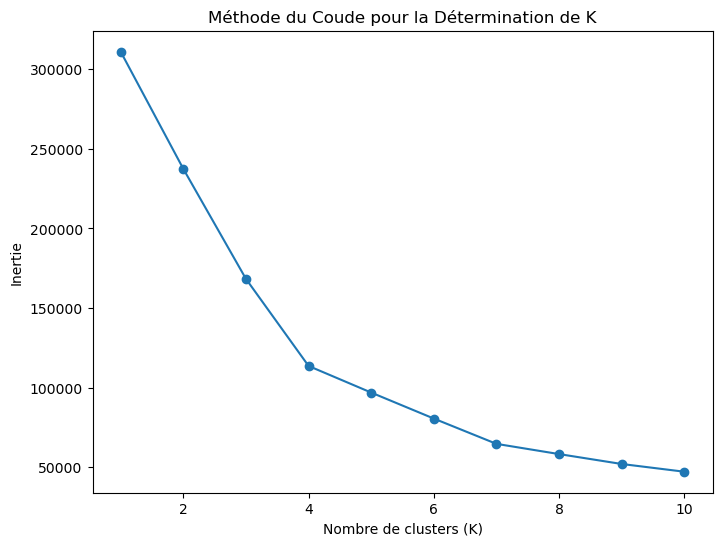

In [7]:
# Méthode du coude
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)


# Tracé du coude
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Méthode du Coude pour la Détermination de K')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('Inertie')
plt.show()

In [8]:
# Methode silhouette

Contraints d'utiliser un sous ensemble de données qui peut influencer 
le nombre de clusters par rapport à la méthode précedente 

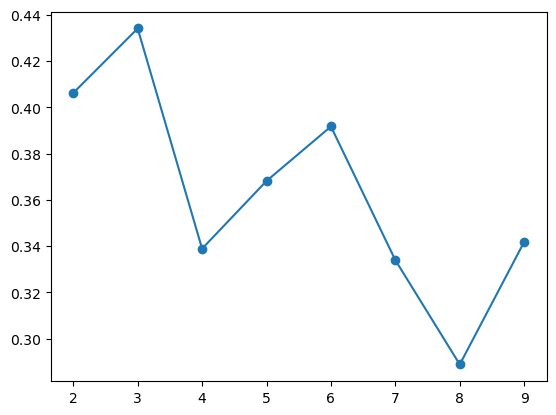

In [9]:
silhouettes = []
for num_clusters in range(2, 10):
    cls = KMeans(n_clusters=num_clusters, n_init=1, init='random')
    cls.fit(rfm_scaled[:10000])
    silh = silhouette_score(X=rfm_scaled[:10000], labels=cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2, 10), silhouettes, marker='o')

## Méthode Davies Bouldin 

/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anacond

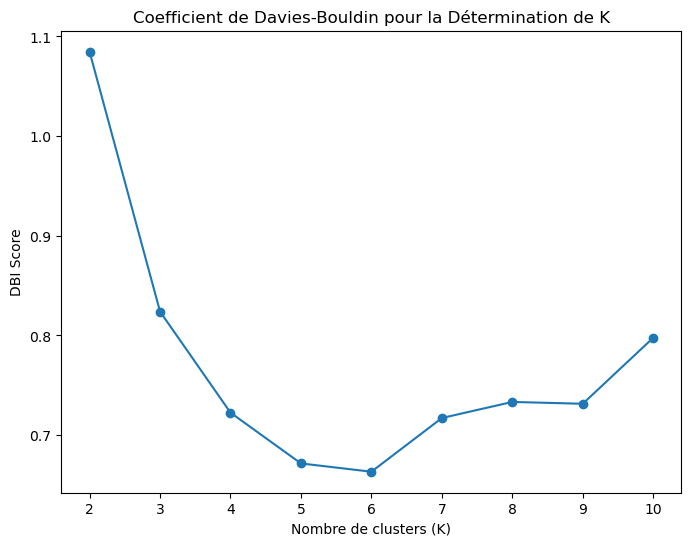

In [10]:

# Initialise une liste pour stocker les scores DBI
dbi_scores = []

# Test différentes valeurs de k
for k in range(2, 11):
    # Appliquez le KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)

    # Calculez le score DBI
    dbi = davies_bouldin_score(rfm_scaled, labels)
    dbi_scores.append(dbi)

# Tracé des scores DBI
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), dbi_scores, marker='o')
plt.title('Coefficient de Davies-Bouldin pour la Détermination de K')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('DBI Score')
plt.show()

/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


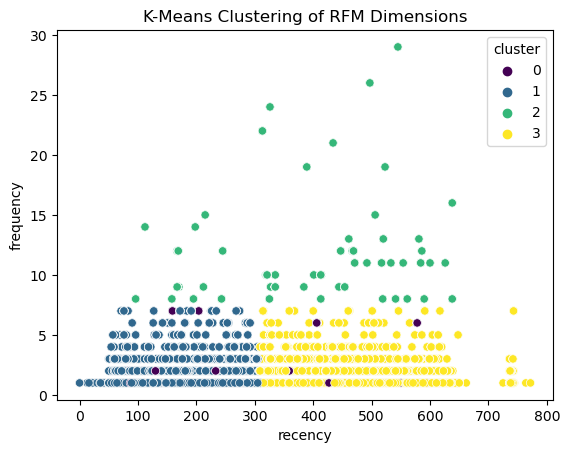

In [11]:
# Appliquer le KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['cluster'] = kmeans.fit_predict(rfm_scaled)

sns.scatterplot(data=rfm_df, x='recency', y='frequency', hue='cluster', palette='viridis')
plt.title('K-Means Clustering of RFM Dimensions')
plt.show()

In [12]:
rfm_df.head()

,Unnamed: 0,customer_id,frequency,monetary,recency,delivery_delay,average_payment_installments,average_review_score,cluster
0,0,00012a2ce6f8dcda20d059ce98491703,1,114.74,337,-6.0,8.0,1.0,3
1,1,000161a058600d5901f007fab4c27140,1,67.41,458,-10.0,5.0,4.0,3
2,2,0001fd6190edaaf884bcaf3d49edf079,1,195.42,596,-16.0,10.0,5.0,3
3,3,0002414f95344307404f0ace7a26f1d5,1,179.35,427,-1.0,1.0,5.0,3
4,4,000379cdec625522490c315e70c7a9fb,1,107.01,198,-5.0,1.0,4.0,1


Text(0.5, 0.92, 'K-Means Clustering of RFM Dimensions in 3D')

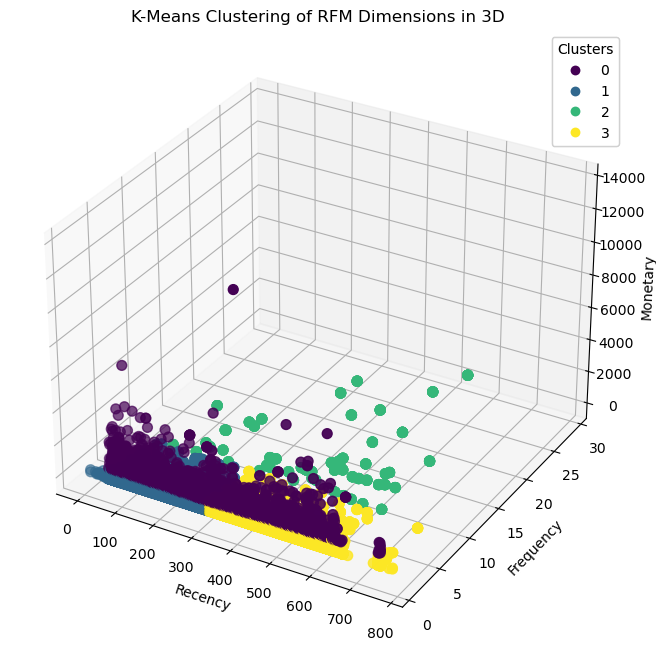

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# Sélectionner les colonnes RFM et les données cluster
rfm_clustered = rfm_df[['recency', 'frequency', 'monetary', 'cluster']]

# Créer une figure en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Tracé des points en fonction des dimensions RFM et de la couleur en fonction du cluster
scatter = ax.scatter(
    rfm_clustered['recency'],
    rfm_clustered['frequency'],
    rfm_clustered['monetary'],
    c=rfm_clustered['cluster'],
    cmap='viridis',
    s=50  # Taille des points
)

# Ajouter une légende
legend = ax.legend(*scatter.legend_elements(), title='Clusters')
ax.add_artist(legend)

# Étiquettes et titre
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('K-Means Clustering of RFM Dimensions in 3D')

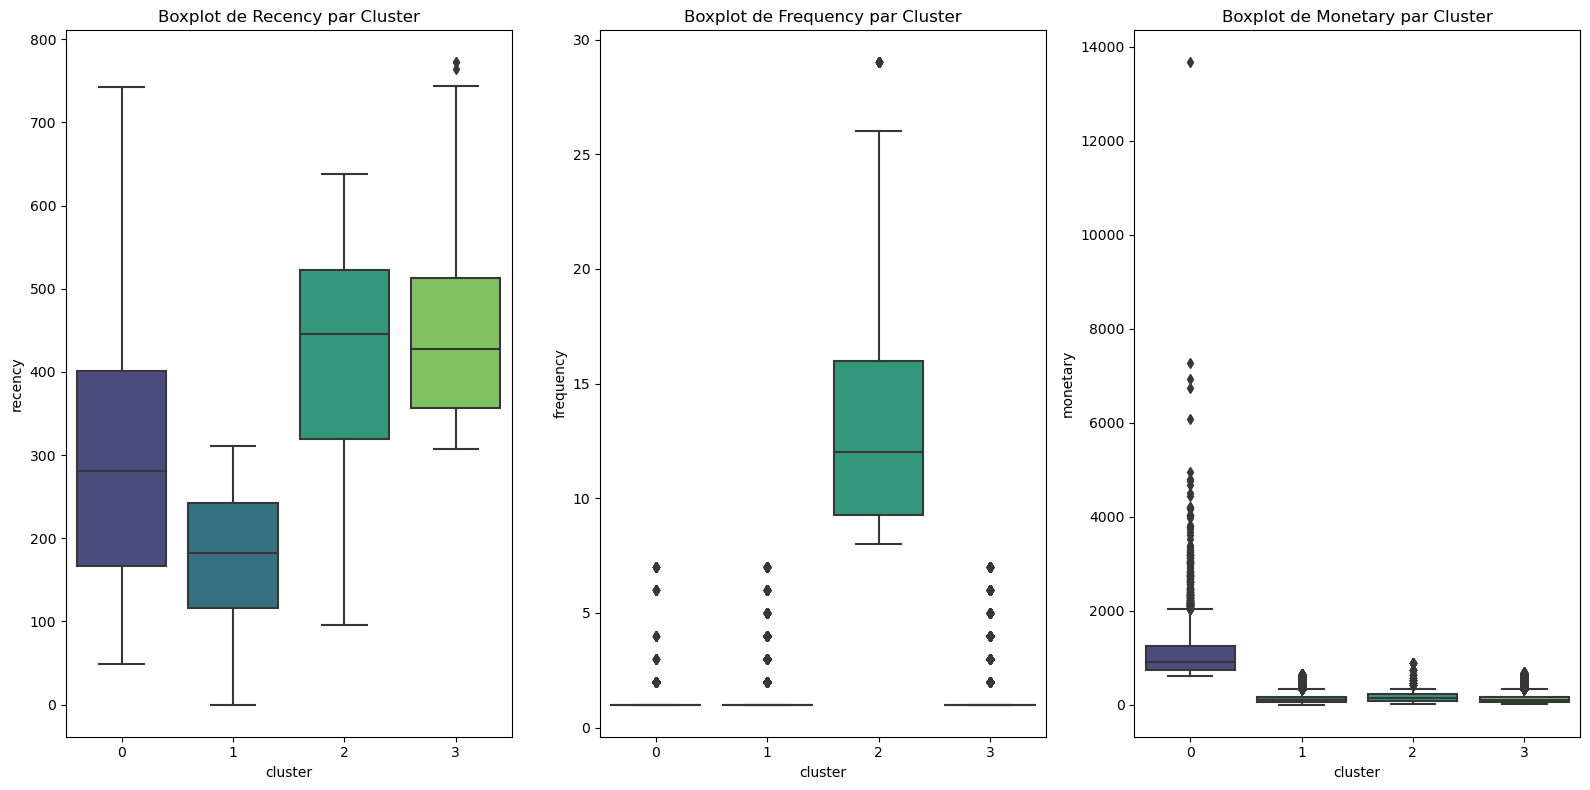

In [14]:
# Boxplots pour 'recency', 'frequency', 'monetary' en fonction de chaque cluster
plt.figure(figsize=(16, 8))

# Boxplot pour 'recency'
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster', y='recency', data=rfm_df, palette='viridis')
plt.title('Boxplot de Recency par Cluster')

# Boxplot pour 'frequency'
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster', y='frequency', data=rfm_df, palette='viridis')
plt.title('Boxplot de Frequency par Cluster')

# Boxplot pour 'monetary'
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster', y='monetary', data=rfm_df, palette='viridis')
plt.title('Boxplot de Monetary par Cluster')

plt.tight_layout()
plt.show()

Cluster 0 : 
- Dépense le plus, relativement récent , fréquence normale 
Cluster 1 : 
- Le plus récent, fréquence normale, dépense le moins 
Cluster 2 : 
- Le moins récent, la meilleure fréquence, dépense un peu plus que le 1 et 3
Cluster 3 : 
- Second moins récent, fréquence normale, second cluster moins dépensier

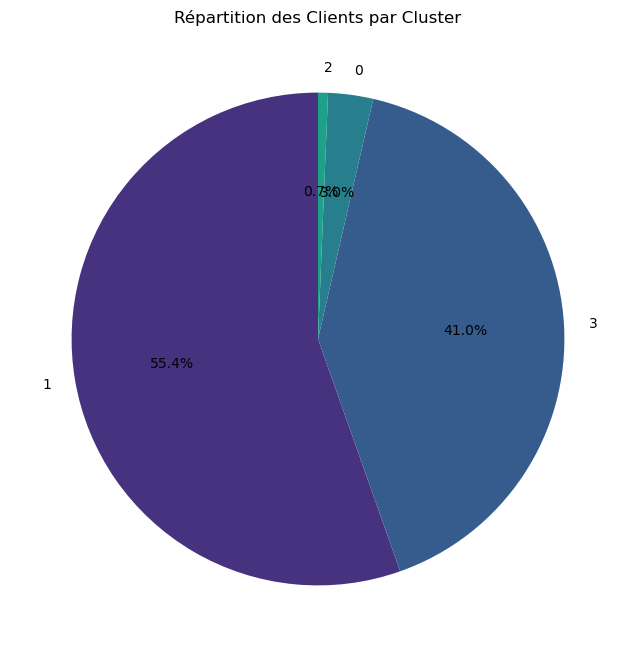

In [15]:
# Compter le nombre de clients dans chaque cluster
cluster_counts = rfm_df['cluster'].value_counts()

# Tracé du pie chart
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
plt.title('Répartition des Clients par Cluster')
plt.show()


Total de la colonne 'monetary': 16815448.34
Contribution de chaque cluster au total (%):
cluster
0    20.109297
1    45.707263
2     0.778267
3    33.405173
Name: monetary, dtype: float64


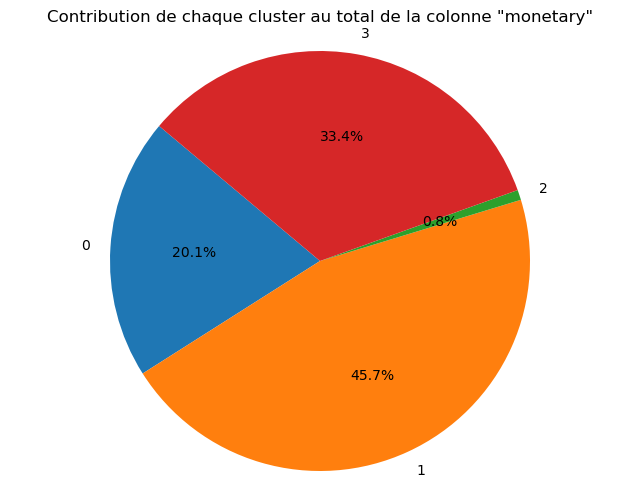

In [16]:
# Calculer le total de la colonne monetary
total_monetary = rfm_df['monetary'].sum()

# Calculer la contribution de chaque cluster au total
cluster_contributions = rfm_df.groupby('cluster')['monetary'].sum() / total_monetary * 100

# Afficher les résultats
print("Total de la colonne 'monetary':", total_monetary)
print("Contribution de chaque cluster au total (%):")
print(cluster_contributions)

# Créer un pie chart pour la contribution de chaque cluster au total
plt.figure(figsize=(8, 6))
plt.pie(cluster_contributions, labels=cluster_contributions.index, autopct='%1.1f%%', startangle=140)
plt.title('Contribution de chaque cluster au total de la colonne "monetary"')
plt.axis('equal')
plt.show()

# Validation croisée dans le temps

In [ ]:
X = data

# Assurez-vous que votre DataFrame est trié chronologiquement
X_sorted = X.sort_values(by='timestamp_column')

# Définissez le nombre de splits pour la validation croisée
n_splits = 5  # Vous pouvez ajuster cela en fonction de la taille de vos données

# Instanciez TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Créez des listes pour stocker les scores de performance
silhouette_scores = []

# Boucle sur les splits de temps
for train_index, test_index in tscv.split(X_sorted):
    # Divisez les données en ensembles d'entraînement et de test
    X_train, X_test = X_sorted.iloc[train_index], X_sorted.iloc[test_index]

    # Effectuez la mise à l'échelle, le prétraitement ou d'autres étapes nécessaires

    # Créez et entraînez le modèle (KMeans dans cet exemple)
    model = KMeans(n_clusters=your_num_clusters, random_state=42)
    model.fit(X_train)

    # Prédisez les clusters sur l'ensemble de test
    test_clusters = model.predict(X_test)

    # Évaluez la performance (utilisez votre propre métrique)
    silhouette = silhouette_score(X_test, test_clusters)
    silhouette_scores.append(silhouette)

# Affichez ou utilisez les scores comme nécessaire
print("Silhouette Scores:", silhouette_scores)
print("Moyenne Silhouette Score:", np.mean(silhouette_scores))

# DBSCAN (Density-Based Spatial Clustering of Applications with Noise) 

### Clusters de points par densité 

L'algorithme DBSCAN (Density-Based Spatial Clustering of Applications with Noise) a été introduit en 1996 dans ce but. Cet algorithme est très utilisé, raison pour laquelle il a obtenu en 2014 une distinction de contribution scientifique ayant résisté à l'épreuve du temps.

DBSCAN itère sur les points du jeu de données. Pour chacun des points qu'il analyse, il construit l'ensemble des points atteignables par densité depuis ce point : il calcule l'epsilon-voisinage de ce point, puis, si ce voisinage contient plus de n_min points, les epsilon-voisinages de chacun d'entre eux, et ainsi de suite, jusqu'à ne plus pouvoir agrandir le cluster. Si le point considéré n'est pas un point intérieur, c'est-à-dire qu'il n'a pas suffisamment de voisins, il sera alors étiqueté comme du bruit. Cela permet à DBSCAN d'être robuste aux données aberrantes, puisque ce mécanisme les isole.

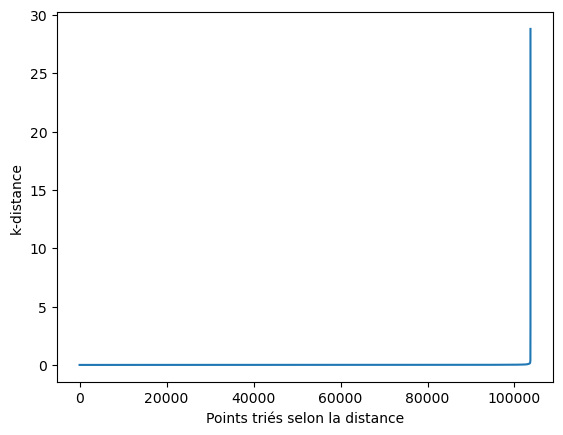

In [18]:
# Calculer la matrice de distances
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(rfm_scaled)
distances, indices = nbrs.kneighbors(rfm_scaled)

# Trier les distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Graphique k-distance
plt.plot(distances)
plt.xlabel("Points triés selon la distance")
plt.ylabel("k-distance")
plt.show()

In [20]:
# Assurez-vous que min_samples est un entier strictement positif
min_samples = 100

# Détermination de eps avec la méthode du graphe k-distance
eps = 10.0  # Remplacez par la valeur que vous souhaitez
neigh = NearestNeighbors(n_neighbors=min_samples)
neigh.fit(rfm_scaled)
distances, indices = neigh.kneighbors(rfm_scaled)
k_distances = distances[:, -1]

# Trier les distances et choisir une valeur pour eps (e.g., le 95e percentile)
eps = np.percentile(k_distances, 95)

# Appliquer DBSCAN avec les paramètres déterminés
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(rfm_scaled)

# Afficher les résultats
print("Étiquettes DBSCAN:")
print(np.unique(labels))
print("Compte de chaque étiquette DBSCAN:")
print(np.bincount(labels + 1)[1:])

# Exclure le cluster de bruit (-1) lors du comptage des clusters
unique_labels = set(labels) - {-1}

# Nombre total de clusters (en excluant le bruit)
num_clusters = len(unique_labels)

print(f"Nombre de clusters estimé : {num_clusters}")

Étiquettes DBSCAN:
[-1  0  1  2  3]
Compte de chaque étiquette DBSCAN:
[93507  5124   246   663]
Nombre de clusters estimé : 4
